In [67]:
import epsbasin
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pandas as pd
from matplotlib.lines import Line2D

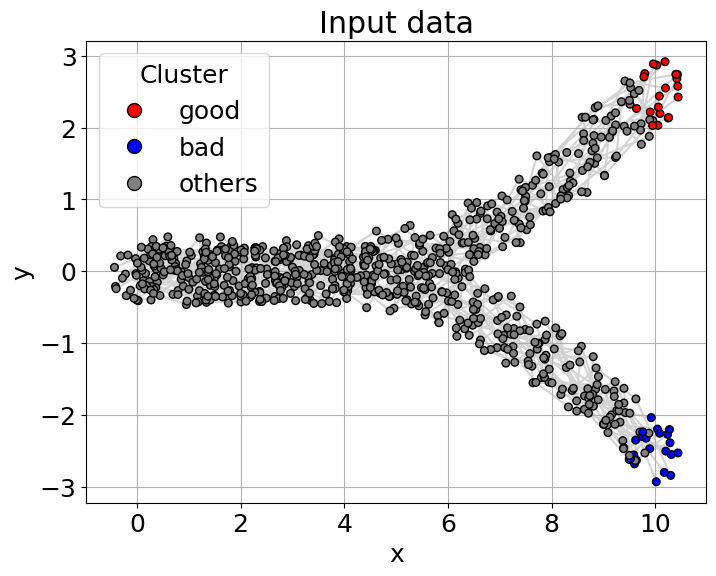

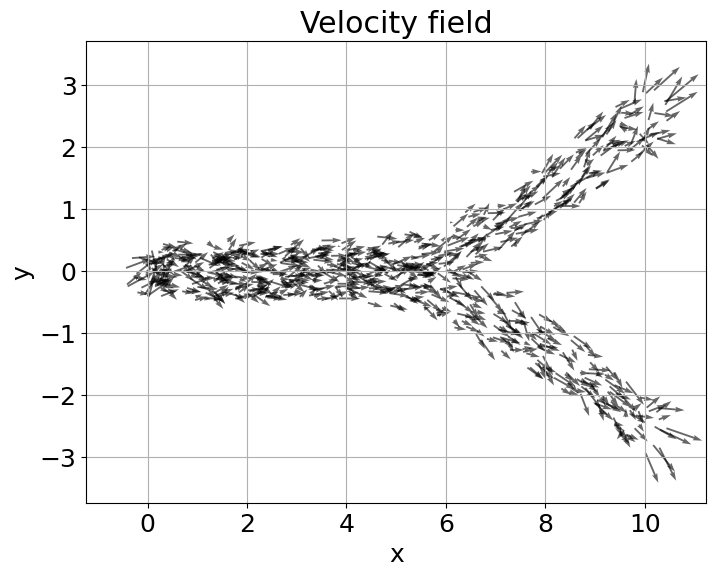

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'x', 'y', 'seq_id', 'cluster'


,x,y,seq_id,cluster
0,0.078550,0.014126,0,others
1,0.142156,0.036562,0,others
2,0.200844,-0.017763,0,others
3,0.308050,-0.010168,0,others
4,0.353551,-0.059388,0,others
...,...,...,...,...
795,1.535531,-0.197895,39,others
796,1.641457,-0.328499,39,others
797,1.858810,-0.371072,39,others
798,1.877425,-0.494281,39,others


In [68]:
xlim = [0,2]
xdiv = 20
scale=5
hill_coef = 5
hill_half = 2.0
I = 20 # length of sequence for one side
noise_scale = 0.1
random_state = 0
np.random.seed(random_state)

def hill_function(x, n=2, K=1):
    """
    Hill function: f(x) = x^n / (K^n + x^n)
    x: input value (array or scalar)
    n: Hill coefficient
    K: half-saturation constant
    """
    return x**n / (K**n + x**n)
def generate_data(xlim, xdiv, hill_coef, hill_half, I, noise_scale):
    x_base = np.linspace(xlim[0], xlim[1], xdiv)
    y_base = hill_function(x_base, n=hill_coef, K=hill_half)
    rng = np.random.default_rng(random_state)
    def uniform_disk_noise(shape, scale, rng):
        r = scale * np.sqrt(rng.uniform(0, 1, size=shape))
        theta = rng.uniform(0, 2 * np.pi, size=shape)
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        return dx, dy

    x_data_top = []
    y_data_top = []
    x_data_bot = []
    y_data_bot = []
    for _ in range(I):
        dx, dy = uniform_disk_noise(x_base.shape, noise_scale, rng)
        x_data_top.append(x_base + dx)
        y_data_top.append(y_base + dy)
        dx, dy = uniform_disk_noise(x_base.shape, noise_scale, rng)
        x_data_bot.append(x_base + dx)
        y_data_bot.append(-y_base + dy)
    x_data_top = np.array(x_data_top)
    y_data_top = np.array(y_data_top)
    x_data_bot = np.array(x_data_bot)
    y_data_bot = np.array(y_data_bot)

    X = np.concatenate([x_data_top, x_data_bot], axis=0)
    Y = np.concatenate([y_data_top, y_data_bot], axis=0)
    data_2d_flat = np.vstack([np.column_stack([X[i], Y[i]]) for i in range(X.shape[0])])
    num_samples, seq_len = X.shape
    sequence_idx = np.repeat(np.arange(num_samples), seq_len)

    df_2d = pd.DataFrame(data_2d_flat, columns=['x', 'y'])
    df_2d['seq_id'] = sequence_idx

    last_idx = np.arange(seq_len - 1, num_samples * seq_len, seq_len)
    df_2d['cluster'] = 'others'
    df_2d.loc[last_idx, 'cluster'] = np.where(df_2d.loc[last_idx, 'y'] > 0, 'good', 'bad')

    adata = anndata.AnnData(X=scale*data_2d_flat)
    adata.obs = df_2d

    return adata
adata = generate_data(xlim, xdiv, hill_coef, hill_half, I, noise_scale)

cluster_colors = {'good': 'red', 'bad': 'blue', 'others': 'gray'}
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8, 6))
for seq_id, group in adata.obs.groupby('seq_id'):
    # group.indexがstr型の場合、intに変換
    idx = group.index.astype(int) if group.index.dtype.kind in {'O', 'U', 'S'} else group.index
    plt.plot(adata.X[idx, 0], adata.X[idx, 1], color='lightgray', alpha=1, zorder=1)
    plt.scatter(adata.X[idx, 0], adata.X[idx, 1], 
                c=group['cluster'].map(cluster_colors), s=30, edgecolor='k', zorder=2)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='good', markerfacecolor='red', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='bad', markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='others', markerfacecolor='gray', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements, title='Cluster')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Input data')
plt.grid(True)
plt.show()


seq_ids = adata.obs['seq_id'].unique()
velocities = []
positions = []

for seq_id in seq_ids:
    seq = adata.obs[adata.obs['seq_id'] == seq_id]
    pos = adata.X[seq.index, :]
    v = np.zeros_like(pos)
    v[1:-1] = (pos[2:] - pos[:-2]) / 2
    v[0] = pos[1] - pos[0]
    v[-1] = pos[-1] - pos[-2]
    velocities.append(v)
    positions.append(pos)

velocities = np.vstack(velocities)
positions = np.vstack(positions)

plt.figure(figsize=(8, 6))
plt.quiver(positions[:, 0], positions[:, 1], velocities[:, 0], velocities[:, 1], 
           angles='xy', scale_units='xy', scale=2, color='k', alpha=0.6, width=0.003)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity field')
plt.grid(True)
x_margin = 0.8
y_margin = 0.8
x_min, x_max = positions[:, 0].min() - x_margin, positions[:, 0].max() + x_margin
y_min, y_max = positions[:, 1].min() - y_margin, positions[:, 1].max() + y_margin
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

print(adata)
display(adata.obs)


In [69]:
epsbasin.eps_attracting_basin(adata, target_cluster_key="good")
epsbasin.eps_attracting_basin(adata, target_cluster_key="bad")
epsbasin.eps_sum_attracting_basin(adata, target_cluster_key="good")
epsbasin.eps_sum_attracting_basin(adata, target_cluster_key="bad")
adata

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'x', 'y', 'seq_id', 'cluster', 'eps_attracting_basin_good', 'eps_attracting_basin_bad', 'eps_sum_attracting_basin_good', 'eps_sum_attracting_basin_bad'
    uns: 'cost_matrix'

In [70]:
adata

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'x', 'y', 'seq_id', 'cluster', 'eps_attracting_basin_good', 'eps_attracting_basin_bad', 'eps_sum_attracting_basin_good', 'eps_sum_attracting_basin_bad'
    uns: 'cost_matrix'

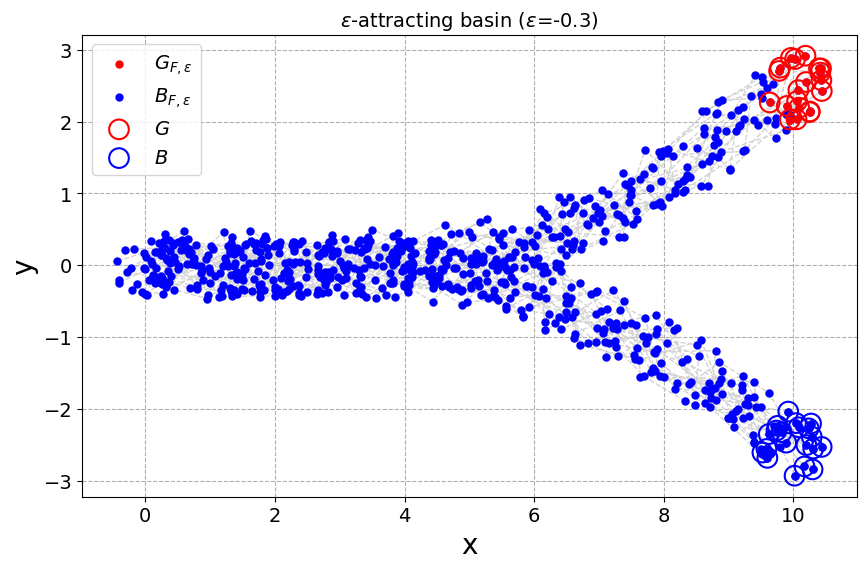

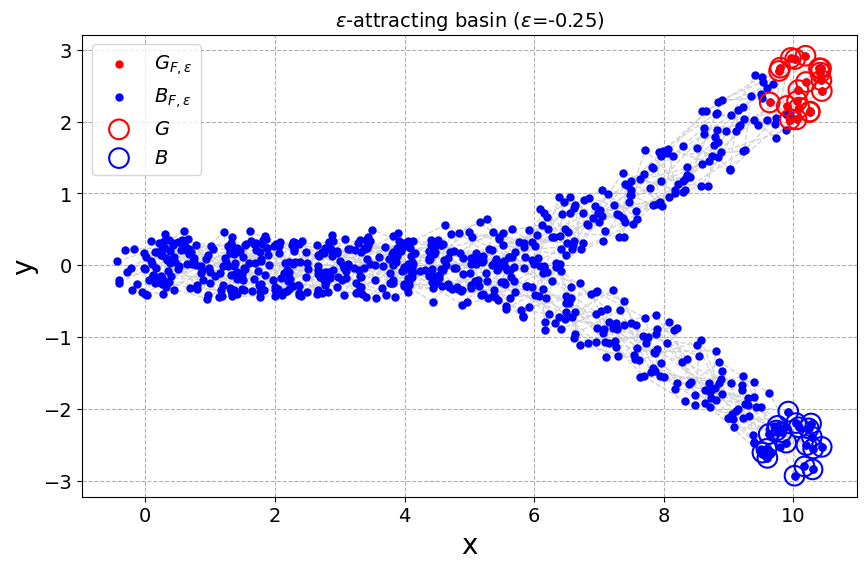

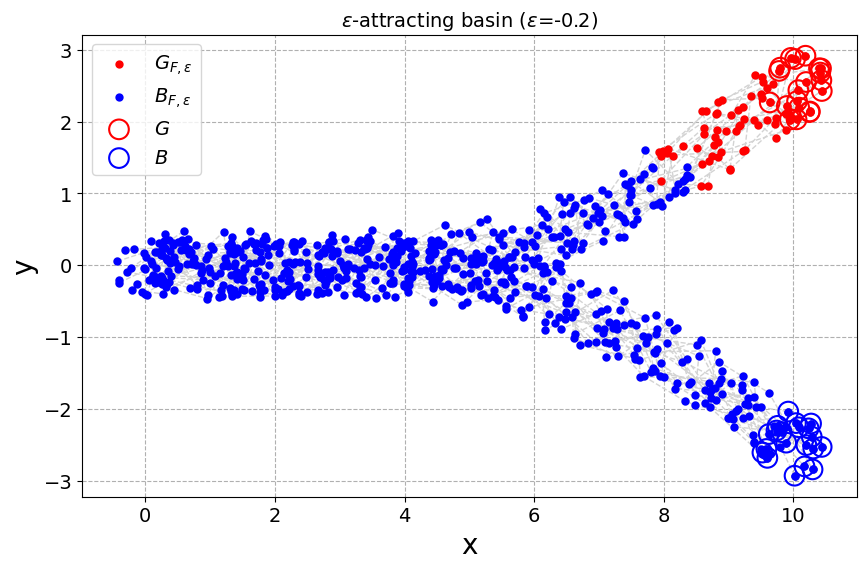

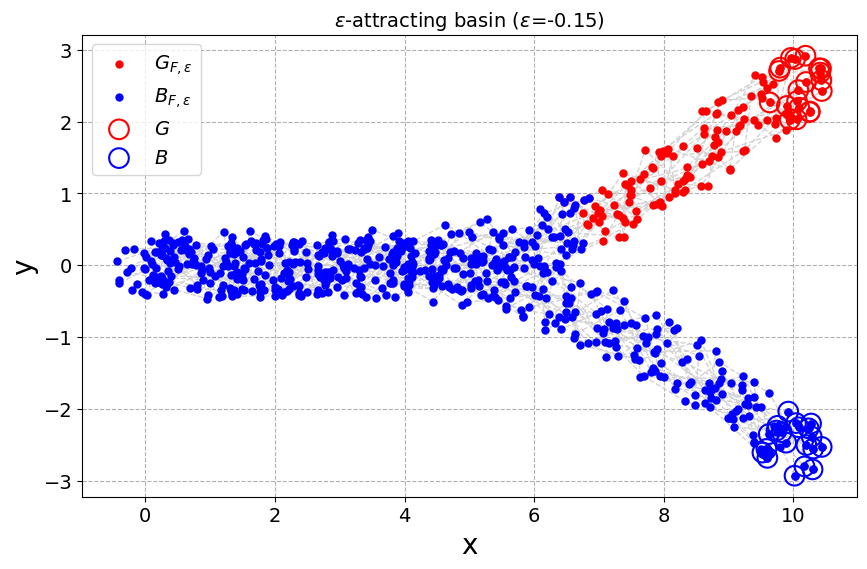

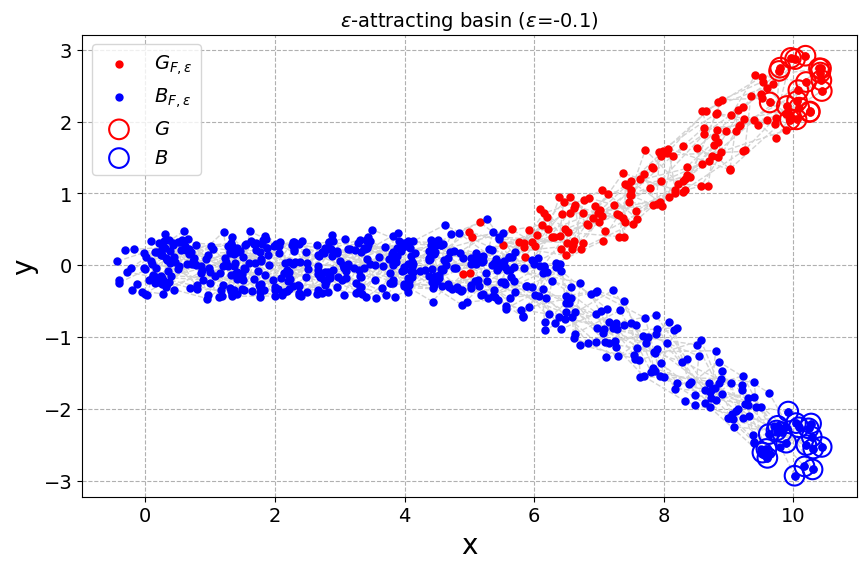

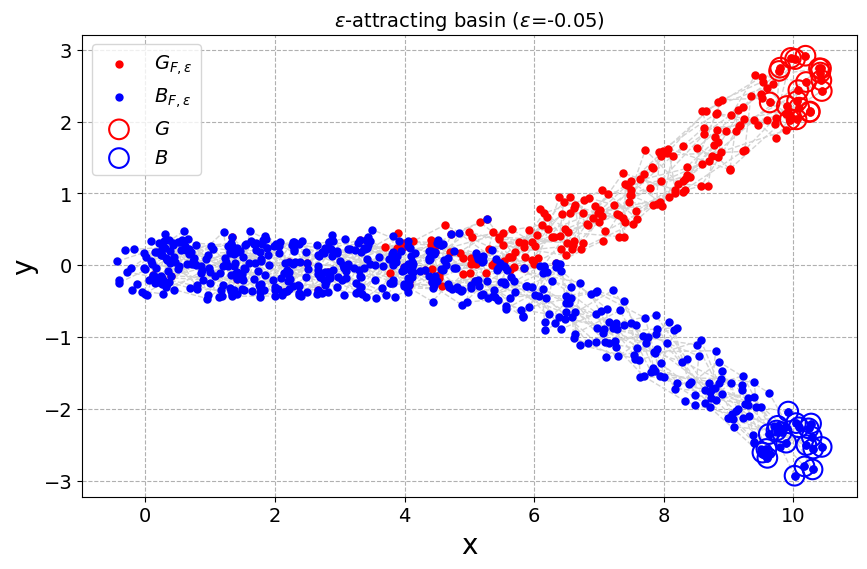

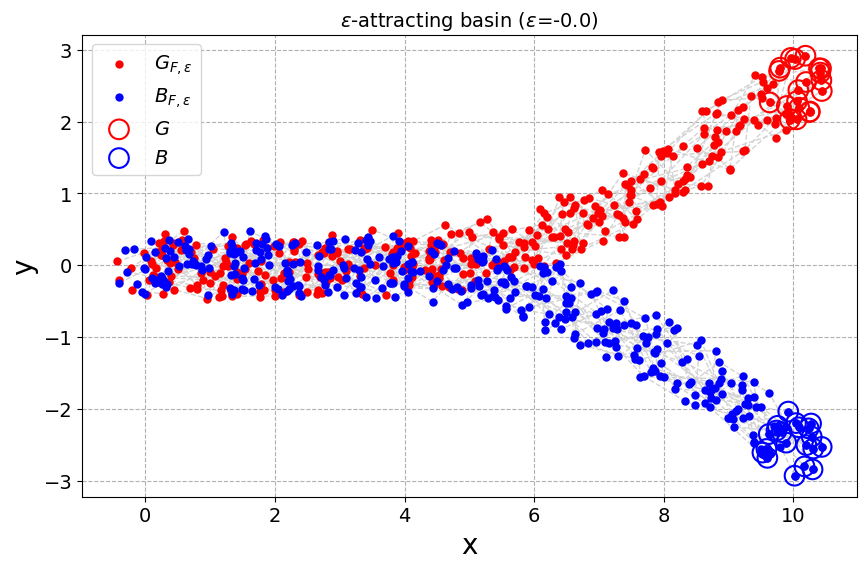

In [ ]:
import importlib
importlib.reload(epsbasin)
eps_thresholds = np.round(np.arange(-0.3, 0.4, 0.05),2)
for eps_threshold in eps_thresholds:
    epsbasin.plot_attracting_basin(adata,eps_key="eps_attracting_basin",eps_threshold=eps_threshold,figsize=(10,6))

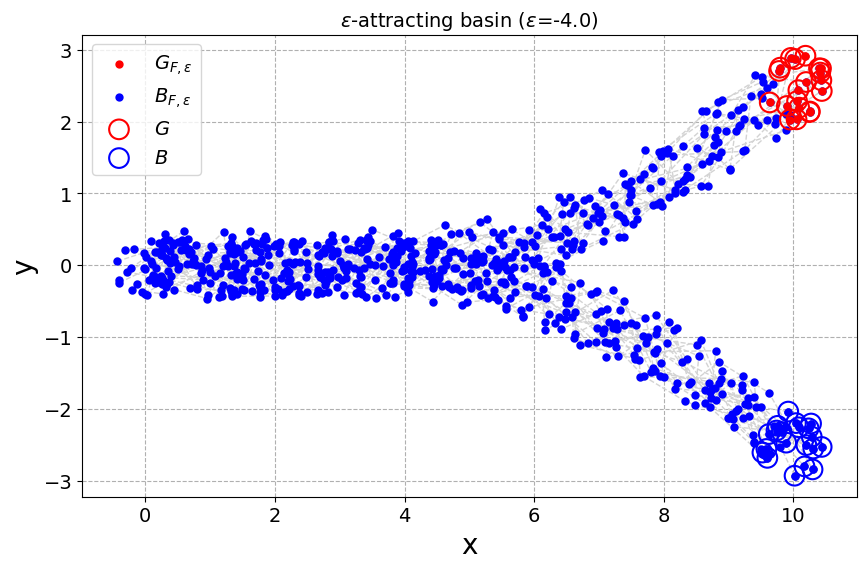

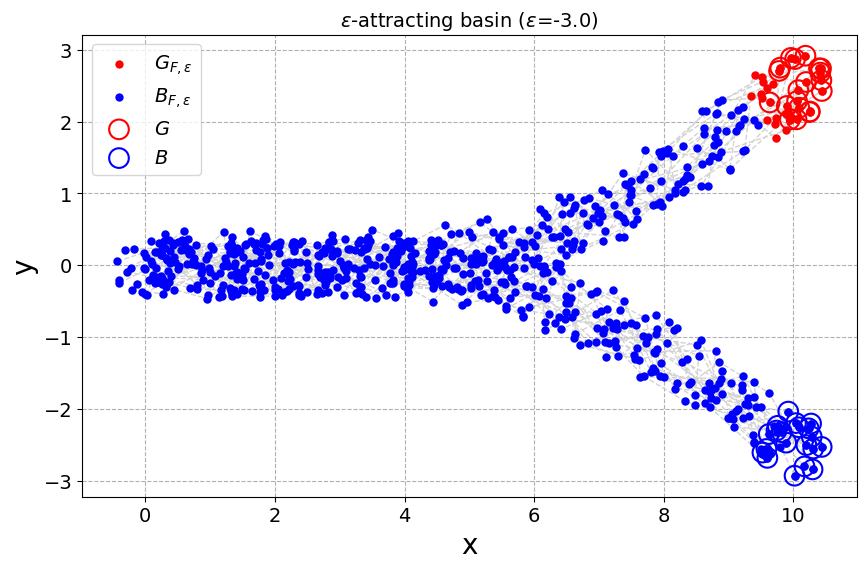

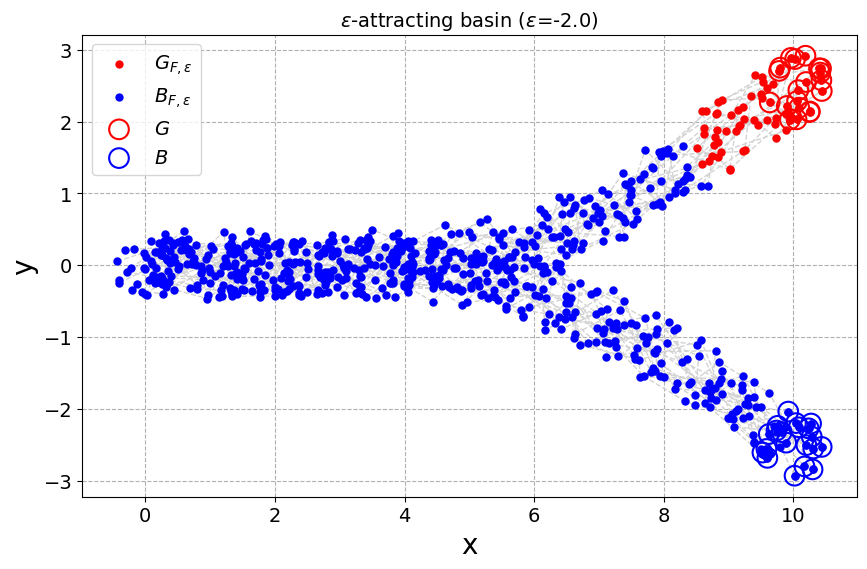

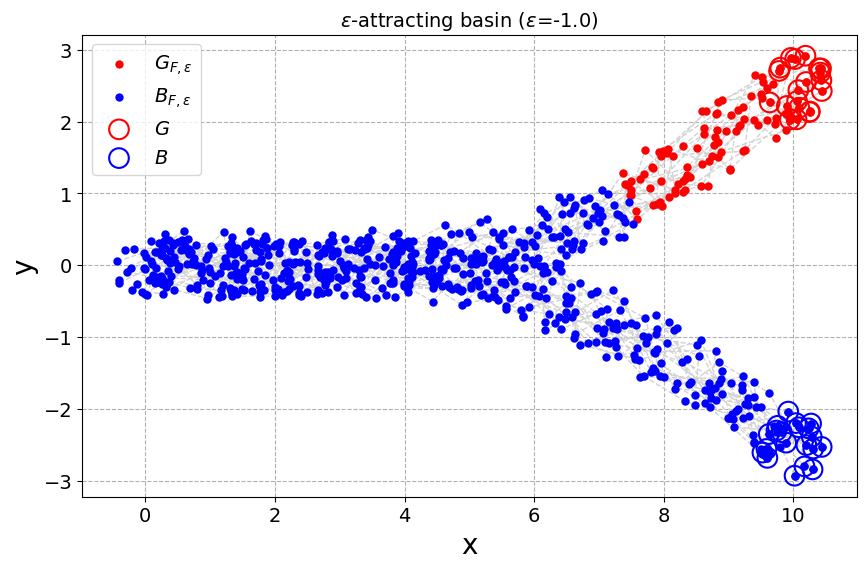

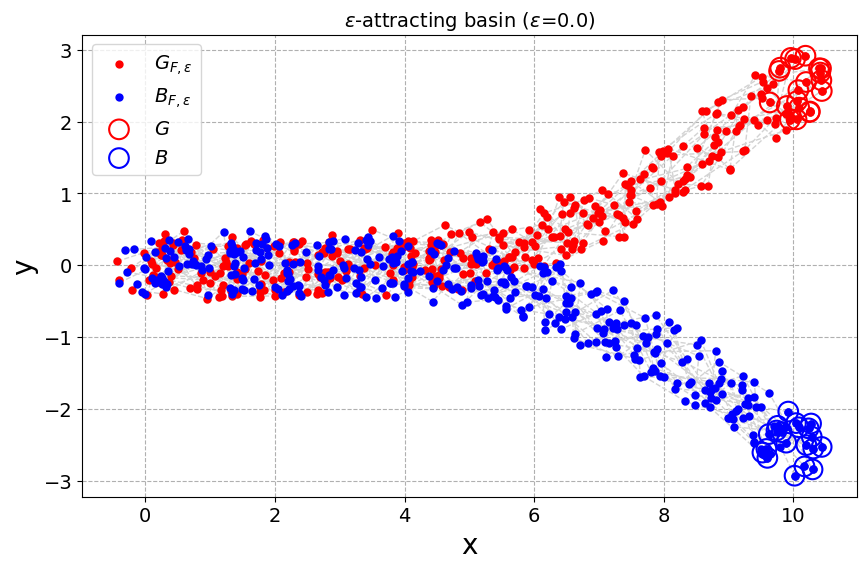

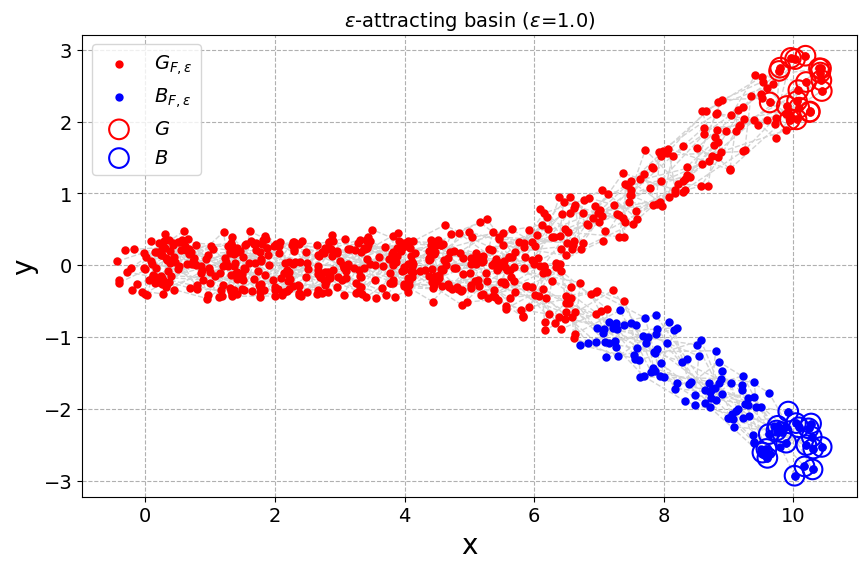

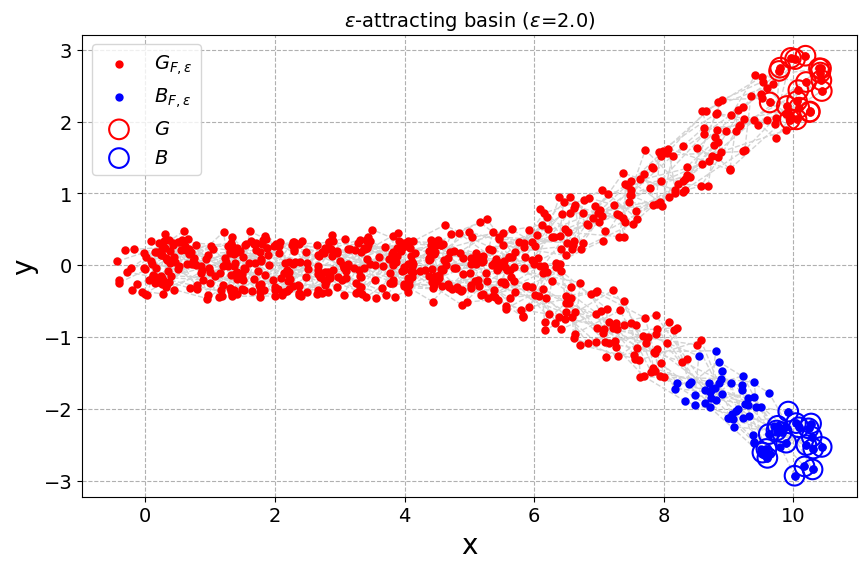

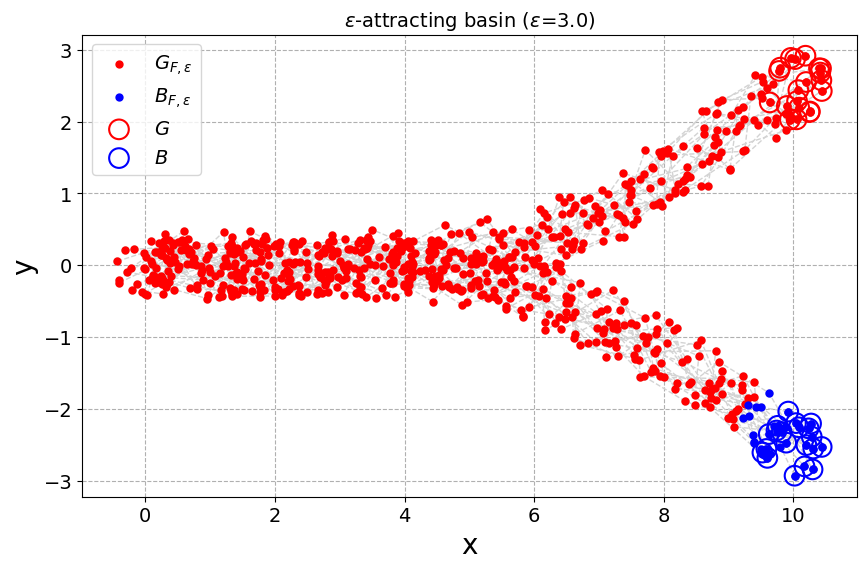

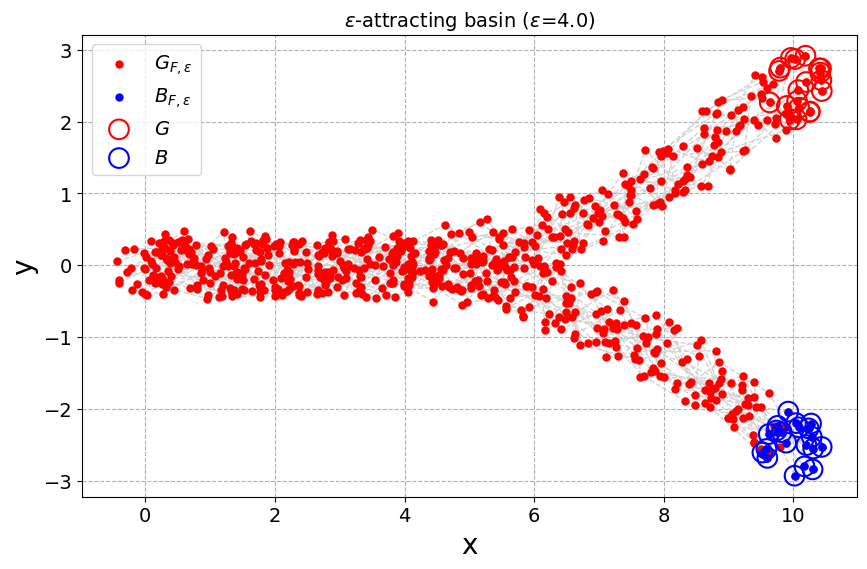

In [ ]:
eps_thresholds = np.round(np.arange(-4, 4.1, 1),2)
for eps_threshold in eps_thresholds:
    epsbasin.plot_attracting_basin(adata,eps_key="eps_sum_attracting_basin",eps_threshold=eps_threshold,figsize=(10,6))

In [ ]:
importlib.reload(epsbasin)
epsbasin.sublevel_set_visualization(adata,eps_key="eps_attracting_basin",target_cluster_key="good",area_percentile=98,edge_percentile=95,vmin=-0.31,vmax=0.31,levels=20,figsize=(10,6))
epsbasin.sublevel_set_visualization(adata,eps_key="eps_attracting_basin",target_cluster_key="bad",area_percentile=98,edge_percentile=95,vmin=-0.31,vmax=0.31,levels=20,figsize=(10,6))
epsbasin.sublevel_set_visualization(adata,eps_key="eps_sum_attracting_basin",target_cluster_key="good",area_percentile=98,edge_percentile=95,vmin=-1.1,vmax=1.1,levels=20,figsize=(10,6))
epsbasin.sublevel_set_visualization(adata,eps_key="eps_sum_attracting_basin",target_cluster_key="bad",area_percentile=98,edge_percentile=95,vmin=-1.1,vmax=1.1,levels=20,figsize=(10,6))

KeyError: 'eps_attracting_basin_good'